<a href="https://colab.research.google.com/github/SWAT-Brasil/util/blob/master/%20/prepara%20precipitacao%20swat/preciptation_to_swat_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conversão de arquivos de precipitação para formato SWAT

Clique no icone do google colab acima para executar o programe.

Utilize ```SHIFT+ENTER``` para executar a célula.

In [4]:
# Verifica se esta rodando no COLAB e instala dependencias
def init_colab_env():
  """ prepara ambiente para uso no COLAB """
  print('Preparando ambiente')
  !rm -r util
  !git clone https://github.com/SWAT-Brasil/util.git


running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  init_colab_env()
else:
    print('AVISO: Google Colab não detectado. Esse notebook pode não funcionar'\
     ' corretamente fora do Google Colab')

Preparando ambiente
Cloning into 'util'...
remote: Enumerating objects: 343, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 343 (delta 97), reused 292 (delta 67), pack-reused 0
Receiving objects: 100% (343/343), 7.55 MiB | 22.03 MiB/s, done.
Resolving deltas: 100% (97/97), done.


In [6]:
import pandas as pd
%matplotlib inline
#%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
import os

In [85]:
def ana2pdserie(filename, consistency = None):
  """ Converte do formato ana para SWAT. 
  filename: caminho para arquivo de precipitacao ANA
  consistency: nivel de consistencia. Se não for declarado utiliza o maior nivel 
    disponivel para um dado
  """

  DATE_COL = 'Data'    # Nome da coluna com data
  TIME_COL = ''    # Nome da coluna com hora
  VARIABLE_COL = []    # Lista com colunas com dados de chuva
  DAY_NUMBER = []    # Lista com numero do dias respectivos ao variable_col
  for i in range(1,31+1):
      VARIABLE_COL.append('Chuva{:02d}'.format(i))
      DAY_NUMBER.append(i)    # numero do dia que equivale ao nome da coluna
  CONSISTENCY_COL = 'NivelConsistencia'

  # Configuracao de formatacao do arquivo de entrada
  DELIMITER = ';'    # delimitator entre campos 
  SKIP_ROWS = 10    # pula esse numero de linha antes de comercar a ler
  ENCODING = 'iso-8859-1'    # Codificacao do arquivo. No Brasil o mais comum eh iso-8859-1. Outro formato comum eh utf-8
  DECIMAL = ','    # Caracter utilizado como decimal

  df = pd.read_csv(INPUT_FILE_NAME, delimiter=DELIMITER, encoding=ENCODING, skiprows=SKIP_ROWS, index_col=False, decimal=DECIMAL)

  # Converte coluna de data de texto para formato interno
  date = pd.to_datetime(df[DATE_COL], format='%d/%m/%Y')

  temp_variable = df[[CONSISTENCY_COL] + VARIABLE_COL]
  temp_variable.index = date
  # Ordena pela data e pelo nivel de consistencia
  temp_variable = temp_variable.sort_values(by = [DATE_COL, CONSISTENCY_COL], ascending = [True, True])

  print('Formato de arquivo: ANA')

  # Aplica o nivel de consistencia
  if consistency:
      temp_variable = temp_variable[temp_variable[CONSISTENCY_COL] == consistency]
      print('Valor de consistencia selecionado: {}'.format(consistency))
  else:
      # Nao foi seleciana consistencia. Utiliza maior valor de consistencia disponivel para uma dada data
      temp_variable = temp_variable[~temp_variable.index.duplicated(keep='last')]
      print('Valor de consistencia nao selecionado. Utilizando o maior disponivel para o dado')
  temp_variable

  # Reconstroi o dataset, usando data com dias, nao somente mes
  serie_temp = []
  index_temp = []
  for index, row in temp_variable.iterrows():
      for val_col, day in zip(VARIABLE_COL, DAY_NUMBER):
          if np.isnan(row[val_col]):
              continue
          # cria o dia. A funcao datetime gera um erro se o dia nao existir)
          try:
              index_temp.append(datetime.datetime(index.year, index.month, day))
          except:
              if row[val_col] == 0.0:
                  print('AVISO: dado {} encontrado no dia inexistente {}-{}-{}'.format(row[val_col], index.year, index.month, day))
                  print('Dado igual a zero (0.0), ignorando dado, deve ser um erro de preenchimento')
                  continue
              else:
                  print('ERRO: dado {} encontrado no dia inexistente {}-{}-{}'.format(row[val_col], index.year, index.month, day))
                  print('Dado diferente de zero em data invalida, oque indica algum problema. Verifique arquivo de entrada')
                  raise
              
          serie_temp.append(row[val_col])
  variable = pd.Series(serie_temp, index_temp)
  return variable

def pdserie2swat(filename_out, serie_in, start_date = None, end_date = None):
  """ Converte serie pandas para format swat """


  # Periodo de inicio/fim serie (ano, mes, dia)
  NO_DATA = -99.0

  #SERIE_START_DATE = datetime.datetime(2000, 1, 1)
  #SERIE_END_DATE = datetime.datetime(2016,12,31)
  #SERIE_START_DATE = start_date
  #SERIE_END_DATE = end_date
  # Seleciona faixa de datas

  if start_date and end_date:
    serie = serie_in[start_date: end_date]
  elif start_date:
    serie = serie_in[start_date]
  elif end_date:
    serie = serie_in[:end_date]
  else:
    serie = serie_in

    # Preenche falhas na sequencia
  # TODO: checar oq ocorre se falta dado no inicio e no fim da serie
  # Verificar Nan ou numero invalido
  date = serie.index[1]
  serie_temp = []
  index_temp = []
  no_data_count = 0

  for index, row in serie.iteritems():
      # completa com NO_DATA se ainda nao tiver index
      # serve para dados anteriores da serie e durante
      while index > date:
          serie_temp.append(NO_DATA)
          index_temp.append(date)
          # incrementa 1 dia
          date += datetime.timedelta(days=1)
          no_data_count += 1
      
      # se for NaN colocar NO_DATA
      if np.isnan(row):
          row = NO_DATA
          no_data_count += 1
          
      # dado existe, vai para a serie
      serie_temp.append(row)
      index_temp.append(date)
      date += datetime.timedelta(days=1)

  # Completa a serie caso o tenha acabado os dados observados mas 
  # nao chegou ao final da serie
  while date <= serie.index[-1]:
      serie_temp.append(NO_DATA)
      index_temp.append(date)
      # incrementa 1 dia
      date += datetime.timedelta(days=1)
      no_data_count += 1
      
      
  serie_out = pd.Series(serie_temp, index_temp) 
  print('Periodo de dados: {} - {}'.format(serie_out.index[1], serie_out.index[-1]))
  print('Numero de dados: {}'.format(serie_out.size))
  print('Numero de NO_DATA: {}'.format(no_data_count))

  # Gera arquivo com valores para calibracao e validacao
  with open(filename_out, 'w') as fo:    
      # Imprime data de inicio no formato AAAAMMDD (ano mes e dia)
      start_date = serie_out.index[0]
      start_date_text =start_date.strftime('%Y%m%d')
      fo.write('{}\n'.format(start_date_text))
      serie_out.to_csv(fo, sep=' ', line_terminator='\n', index=False, header=None)

  print('Arquivo de saida: {}'.format(filename_out))

def ana2swat(filename_in, filename_out = None, consistency = None):
  """ Converte arquivo de precipitacao ANA para swat
  filename_out: nome do arquivo de saida. Se nao for declarado é gerado automaticamente
  consistency: nivel de consistencia, geralmente 1 ou 2 para ANA. Se nao declarado é utilizado o dado como maior nivel de consistencia
  """
  # Gera nome do arquivo de saida a partir do de entrada. Geralmente não precisa ser alterado
  if filename_out is None:
    path, filename = os.path.split(filename_in)
    filename, ext = os.path.splitext(filename)
    newfilename = 'ana_precip_to_swat_{}.txt'.format(filename)
    
    filename_out = os.path.join(path, newfilename)    # Nome do arquivo de saida com dados processados para uso no SWAT
    ID = filename    # Codigo identificador da estacao, para ser utilizano no comentario do dado. Serve para confirmar a origem do dado

  pcp_serie = ana2pdserie(filename_in)
  pdserie2swat(filename_out, pcp_serie)

  # Retorna o nome do arquivo criado
  return filename_out

def stats_swat(filename):
  # TODO: colocar mais algumas estatisticas aqui

  # Configuracao de formatacao do arquivo de entrada
  DELIMITER = ';'    # delimitator entre campos 
  SKIP_ROWS = 0    # pula esse numero de linha antes de comercar a ler
  ENCODING = 'iso-8859-1'    # Codificacao do arquivo. No Brasil o mais comum eh iso-8859-1. Outro formato comum eh utf-8
  DECIMAL = '.'    # Caracter utilizado como decimal
  NO_DATA = -99.0
  # Abre arquivo com pandas
  df = pd.read_csv(filename, delimiter=DELIMITER, encoding=ENCODING, skiprows=SKIP_ROWS, index_col=False, decimal=DECIMAL)

  # Converte coluna de data de texto para formato interno
  date = pd.to_datetime(df.columns[0], format='%Y%m%d')
  temp_variable = df[df.columns[0]]

  # Reconstroi o dataset, usando data com dias, nao somente mes
  serie_temp = []
  index_temp = []
  for index, row in temp_variable.iteritems():
      index_temp.append(date + datetime.timedelta(days=index))
      if row == NO_DATA:
          serie_temp.append(np.nan)
      else:
          serie_temp.append(row)
  variable = pd.Series(serie_temp, index_temp)

  print("Estatisticas precipitacao SWAT")
  print(variable)

  plt.figure()
  plt.plot(variable)
  plt.title('Precipitacao diaria')

  plt.figure()
  # Acumula mensal para usuario conseguir identificar possíveis falhas 
  acc_month = variable.groupby([variable.index.year, variable.index.month]).sum()
  index_month = [datetime.date(m[0],m[1], 1) for m in acc_month.index]
  plt.bar(index_month, acc_month.values, width=90)
  plt.xticks(rotation=45)
  plt.title('Precipitacao mensal')

  plt.figure()
  # Acumula anual para usuario conseguir identificar possíveis falhas 
  acc_year = variable.groupby(variable.index.year).sum()
  plt.bar(acc_year.index, acc_year)
  plt.xticks(rotation=45)
  plt.title('Precipitacao anual')

Formato de arquivo: ANA
Valor de consistencia nao selecionado. Utilizando o maior disponivel para o dado
Periodo de dados: 2000-09-09 00:00:00 - 2019-12-31 00:00:00
Numero de dados: 7054
Numero de NO_DATA: 30
Arquivo de saida: util/prepara precipitacao swat/test/ana/ana_precip_to_swat_chuvas_C_01045006.txt
Estatisticas precipitacao SWAT
2000-09-08    43.6
2000-09-09    32.7
2000-09-10     0.0
2000-09-11     0.0
2000-09-12     0.0
              ... 
2019-12-27     0.0
2019-12-28     0.0
2019-12-29     0.0
2019-12-30     1.5
2019-12-31     0.2
Length: 7054, dtype: float64


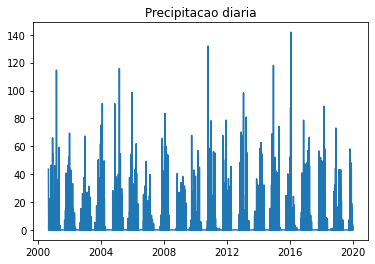

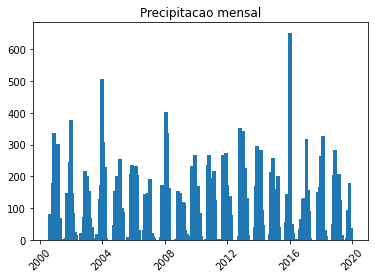

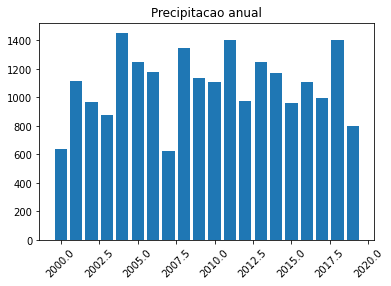

In [86]:
# converte arquivo de ana para swat
out = ana2swat(INPUT_FILE_NAME)
# Mostra uma analise superficial dos dados
stats_swat(out)